In [132]:
# !pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq
!pip install mplfinance -qqq

# Import Libraries

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

np.random.seed(100)

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.18.0


# Data

In [134]:
# @title Generate time series dataset from Yahoo Finance

def fetch_yfinance_data(ticker, start_date, end_date, interval='1d'):
  """
  Fetches Yahoo Finance data, checks for and fills missing values,
  and ensures a single-level column index.

  Args:
    ticker (str): The stock ticker symbol (e.g., 'AAPL').
    start_date (str): The start date for data fetching (YYYY-MM-DD).
    end_date (str): The end date for data fetching (YYYY-MM-DD).

  Returns:
    pd.DataFrame: The fetched and preprocessed stock data with a
                  single-level column index.
  """
  # Fetch data
  data = yf.download(ticker, start=start_date, end=end_date, interval=interval)

  # Check for missing values
  print(f"Missing values before filling for {ticker}:")
  print(data.isnull().sum())

  # Display the first few rows of the dataframe
  print(f"First 5 rows of {ticker} data:")
  print(data.head())

  # Checking for missing values
  print(f"\nMissing values before filling for {ticker}:")
  print(data.isnull().sum())

  # Filling missing values, if any
  data.ffill(inplace=True)

  print(f"\nMissing values after filling for {ticker}:")
  print(data.isnull().sum())

  # Flatten the column index if it's multi-level
  if isinstance(data.columns, pd.MultiIndex):
      # Extract column names from the first level (index 0) of the multi-index
      # This assumes OHLCV labels are at the top level
      data.columns = data.columns.get_level_values(0)
      print("\nMulti-level column names flattened to top level (OHLCV labels).")
  else:
      # If already a single-level index, ensure names are just strings
      data.columns = data.columns.astype(str)
      print("\nDataFrame already had a single-level column index.")

  print("\nDataFrame columns after flattening:")
  print(data.columns)

  return data


In [135]:
# Fetch AAPL data
symbol = 'AAPL'
aapl_data = fetch_yfinance_data(symbol, '2020-01-01', '2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()


[*********************100%***********************]  1 of 1 completed

First 5 rows of AAPL data:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.620827  72.681274  71.373203  71.627077  135480400
2020-01-03  71.914818  72.676447  71.689957  71.847118  146322800
2020-01-06  72.487854  72.526541  70.783256  71.034717  118387200
2020-01-07  72.146942  72.753823  71.926915  72.497529  108872000
2020-01-08  73.307510  73.609745  71.849533  71.849533  132079200

Missing values before filling for AAPL:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Missing values after filling for AAPL:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Multi-level column names flattened to top level (OHLCV labels).

DataFrame columns after flattening:
Index(

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.620827,72.681274,71.373203,71.627077,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487854,72.526541,70.783256,71.034717,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200


In [136]:
# @title Generate a synthetic time series dataset

def generate_synthetic_time_series(num_points=1000, step_size=0.1, noise_level=0.1):
  """
  Generates a synthetic time series dataset based on a sine wave with added noise.

  Args:
    num_points (int): The number of data points to generate.
    step_size (float): The step size between data points in the time series.
    noise_level (float): The standard deviation of the random noise to add.

  Returns:
    tuple: A tuple containing two numpy arrays:
           - X (np.ndarray): The input sequence (all points except the last).
           - y (np.ndarray): The target sequence (all points except the first).
  """
  time = np.arange(0, num_points * step_size, step_size)
  # Generate a sine wave and add random normal noise
  amplitude = np.sin(time) + np.random.normal(0, noise_level, len(time))

  # Create input (X) and target (y) sequences for time series prediction
  # X consists of all data points except the last one
  X = amplitude[:-1]
  # y consists of all data points except the first one (the next value for each X)
  y = amplitude[1:]

  return X, y


In [137]:
X_synthetic, y_synthetic = generate_synthetic_time_series(num_points=100, step_size=0.1, noise_level=0.1)

X_synthetic


array([-0.17497655,  0.13410146,  0.31397291,  0.2702766 ,  0.48755042,
        0.53084742,  0.58676044,  0.53721335,  0.69840651,  0.80882705,
        0.79566829,  0.93472371,  0.87367958,  1.04524289,  1.05272181,
        0.98705387,  0.94644557,  1.09463808,  0.93003407,  0.83446826,
        1.07119559,  1.01736988,  0.78330849,  0.66146164,  0.69391505,
        0.69218036,  0.58860141,  0.56353549,  0.30236434,  0.24481693,
        0.16335997, -0.10274104, -0.13400937, -0.07610029, -0.18049663,
       -0.39637792, -0.32355822, -0.69889782, -0.7474978 , -0.81100961,
       -0.81124641, -0.88509428, -0.87084432, -0.97745981, -0.82162727,
       -1.15083968, -1.09202201, -0.96417248, -1.15752246, -0.83538123,
       -1.07772603, -0.9807893 , -0.97745927, -0.91506068, -0.76187814,
       -0.65475937, -0.71748937, -0.42573857, -0.4725633 , -0.46284981,
       -0.36759534, -0.18029861, -0.05930494,  0.01816876, -0.04700374,
        0.110699  ,  0.37284525,  0.47847044,  0.5968055 ,  0.43

# Pattern Detection

U => Up

D => Down


Verify the effectiveness of these patterns by checking if they appear near points where the price was rejected.


In [190]:

def analyze_price_movements(df, n_values=[4, 8]):
  """
  Analyzes price movements in a DataFrame and creates 'last_n' and 'next_n'
  columns based on the 'Close' and 'Open' prices.

  Args:
    df (pd.DataFrame): The input DataFrame with 'Open' and 'Close' columns.
    n_values (list): A list of integers specifying the lookback and lookahead
                     periods for creating 'last_n' and 'next_n' columns.

  Returns:
    pd.DataFrame: The DataFrame with 'Movement', 'last_n', and 'next_n' columns
                  added for each n in n_values.
  """
  # Create the 'Movement' column (handling cases where Close == Open)
  df['Movement'] = df.apply(lambda row: 'U' if row['Close'] > row['Open'] else ('D' if row['Close'] < row['Open'] else 'NaN'), axis=1)

  # Define functions to get the last and next n movements
  def get_last_n_movements(movements, n):
      # Filter out NaN values and ensure the movements list is complete
      movements = [m for m in movements if m != 'NaN' and not (isinstance(m, float) and np.isnan(m))]
      return ''.join(movements[-n:]) if len(movements) >= n else 'NaN'

  def get_next_n_movements(movements, n):
      # Filter out NaN values and ensure the movements list is complete
      movements = [m for m in movements if m != 'NaN' and not (isinstance(m, float) and np.isnan(m))]
      return ''.join(movements[:n]) if len(movements) >= n else 'NaN'

  # Populate 'last_n' and 'next_n' columns for each n in n_values
  for n in n_values:
      last_col_name = f'last_{n}'
      next_col_name = f'next_{n}'

      # Initialize the new columns
      df[last_col_name] = 'NaN'
      df[next_col_name] = 'NaN'

      # Populate 'last_n' column
      for i in range(len(df)):
          df.at[i, last_col_name] = get_last_n_movements(df['Movement'].iloc[max(0, i - (n - 1)):i+1], n)

      # Populate 'next_n' column
      # We iterate up to len(df) - n to ensure we have enough future movements
      for i in range(len(df) - n):
          df.at[i, next_col_name] = get_next_n_movements(df['Movement'].iloc[i+1:i+1+n], n)

  return df


In [191]:
n_values = [2, 3, 4, 8] # 12 is too much
pr_df = analyze_price_movements(aapl_data, n_values=n_values)
pr_df.head()

Price,Close,High,Low,Open,Volume,Movement,last_2,next_2,last_3,next_3,last_4,next_4,last_8,next_8,next_4_label
Date,,,,,,,,,,,,,,,
2020-01-02 00:00:00,72.620827,72.681274,71.373203,71.627077,135480400.0,U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-03 00:00:00,71.914818,72.676447,71.689957,71.847118,146322800.0,U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-06 00:00:00,72.487854,72.526541,70.783256,71.034717,118387200.0,U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-07 00:00:00,72.146942,72.753823,71.926915,72.497529,108872000.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-08 00:00:00,73.307510,73.609745,71.849533,71.849533,132079200.0,U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [140]:
# Display some columns for verification

# Generate column names using a list comprehension
columns_to_display = [f'last_{n}' for n in n_values] + [f'next_{n}' for n in n_values]

pr_df[columns_to_display].dropna(axis=0)

Price,last_2,last_3,last_4,last_8,next_2,next_3,next_4,next_8
Date,,,,,,,,
2020-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1001,DD,DDD,UDDD,UUUDUDDD,DU,DUD,DUDD,NaN
1002,DD,DDD,DDDD,UUDUDDDD,UD,UDD,NaN,NaN
1003,DU,DDU,DDDU,UDUDDDDU,DD,NaN,NaN,NaN


In [141]:
# Count occurrences in 'last_2' column
last_2_counts = pr_df['last_2'].value_counts()
last_2_counts

,count
last_2,
NaN,1009
UU,285
UD,263
DU,262
DD,193


In [142]:
# Count occurrences in 'last_3' column
last_3_counts = pr_df['last_3'].value_counts()
last_3_counts

,count
last_3,
NaN,3021
UUU,153
UDU,142
UUD,132
DUU,131
DUD,131
UDD,121
DDU,120
DDD,71


In [143]:
# Count occurrences in 'last_4' column
last_4_counts = pr_df['last_4'].value_counts()
last_4_counts

,count
last_4,
NaN,5032
UUUU,91
UDDU,76
DUDU,74
UDUD,73
DUUD,70
UDUU,69
UUDU,68
UUDD,64


In [144]:
# Count occurrences in 'last_8' column
last_8_counts = pr_df['last_8'].value_counts()
last_8_counts

,count
last_8,
NaN,7048
UDDUUDDU,13
UUUUUUUU,12
UUDUDDUU,10
DUDDUUDD,10
...,...
DDDUUDUD,1
DDUUDUUU,1
UUDUDDDU,1


In [145]:
# Count occurences in 'next_4 column
next_4_counts = pr_df['next_4'].value_counts()
next_4_counts

,count
next_4,
NaN,6035
UUUU,91
UDDU,76
DUDU,74
UDUD,73
DUUD,70
UDUU,69
UUDU,68
UUDD,64


# Models

### Utilities

In [146]:

def create_time_series_dataset(data, time_step=1):
  """
  Creates a time series dataset with input sequences and corresponding targets.

  Args:
    data (np.ndarray): The input time series data (assumed to be a 2D array
                       with the time series in the first column).
    time_step (int): The number of previous time steps to use as input features.

  Returns:
    tuple: A tuple containing two numpy arrays:
           - X (np.ndarray): The input sequences.
           - y (np.ndarray): The target values.
  """
  X = []
  y = []
  for i in range(len(data) - time_step - 1):
    # Extract the input sequence
    input_sequence = data[i:(i + time_step), 0]
    X.append(input_sequence)
    # Extract the target value (the next step)
    target_value = data[i + time_step, 0]
    y.append(target_value)

  return np.array(X), np.array(y)

# assuming scaled_data is a NumPy array:
# time_step = 100
# X, y = create_time_series_dataset(scaled_data, time_step)


In [147]:
# @title Define Data Preparation Function

def prepare_data_for_model(dataframe, features_list, target="Close", shift_periods=1):
    """
    Prepares time series data for MODEL by creating features (X) and target (y)
    where y is the 'Close' price shifted forward by shift_periods.
    Includes robust handling of NaN and Inf values.

    Args:
        dataframe (pd.DataFrame): The input DataFrame with time series data.
        features_list (list): A list of column names to use as features.
        target (str): The column name of the target variable.
        shift_periods (int): The number of periods to shift the target forward.
                             A positive value means predicting into the future.

    Returns:
        tuple: A tuple containing two numpy arrays:
               - X (np.ndarray): The feature sequences.
               - y (np.ndarray): The target values.
    """
    # Make a copy to avoid modifying the original dataframe slice in place
    df_processed = dataframe.copy()

    # --- Step 1: Initial cleaning of selected features and target ---
    # Check and handle NaNs/Infs in relevant columns *before* shifting
    cols_to_check = features_list + [target]
    for col in cols_to_check:
        if col not in df_processed.columns:
             raise ValueError(f"Column '{col}' not found in DataFrame.")
        if df_processed[col].isnull().any():
            print(f"Warning: NaNs found in column '{col}'. Filling NaNs with ffill.")
            # Using ffill *again* just in case, although fetch_yfinance_data should do this
            df_processed[col].ffill(inplace=True)
            # Optional: bfill after ffill to handle NaNs at the beginning
            df_processed[col].bfill(inplace=True)
        if np.isinf(df_processed[col]).any():
            print(f"Warning: Infs found in column '{col}'. Replacing with NaN and then filling.")
            df_processed[col].replace([np.inf, -np.inf], np.nan, inplace=True)
            # Fill NaNs created by replacement
            df_processed[col].ffill(inplace=True)
            df_processed[col].bfill(inplace=True)


    # --- Step 2: Create features (X) and shifted target (y) ---
    X = df_processed[features_list].to_numpy()

    # Create the target (y) by shifting 'Close' price forward
    y_shifted = df_processed[target].shift(-shift_periods)

    # Convert shifted y to numpy
    y = y_shifted.to_numpy()

    # --- Step 3: Align X and y by removing rows with NaN targets ---
    # This happens at the end of the shifted series when shift_periods > 0
    # We need to ensure X and y correspond correctly in time
    # If y_i is the price at time t + shift_periods, X_i should be data at time t.
    # Shifting y up by shift_periods aligns y_i with X_i corresponding to time t.
    # So we take samples from the start up to the point where y is not NaN.

    # Find indices where the shifted target is NOT NaN
    valid_indices = ~np.isnan(y)

    # Apply the mask to both X and y to keep only rows where y is valid
    X_aligned = X[valid_indices]
    y_aligned = y[valid_indices]

    # --- Step 4: Final Check for NaNs/Infs after alignment ---
    # This is a last safeguard. If any NaN/Inf slipped through, we find and remove those rows.
    # Combine X and y into a temporary array to easily check row-wise
    # Ensure y_aligned is 2D for hstack
    y_aligned_2d = y_aligned.reshape(-1, 1) if y_aligned.ndim == 1 else y_aligned

    combined = np.hstack((X_aligned, y_aligned_2d))
    nan_inf_rows_mask = np.isnan(combined).any(axis=1) | np.isinf(combined).any(axis=1)

    X_cleaned = combined[~nan_inf_rows_mask, :-1]
    y_cleaned = combined[~nan_inf_rows_mask, -1] # Take the last column as target


    assert len(X_cleaned) == len(y_cleaned), f"Lengths of cleaned X and y do not match: {len(X_cleaned)} != {len(y_cleaned)}"
    print(f"Data prepared with {len(X_cleaned)} samples for shift periods: {shift_periods}")
    print(f"Final check for NaNs/Infs in X_cleaned: {np.isnan(X_cleaned).any() or np.isinf(X_cleaned).any()}")
    print(f"Final check for NaNs/Infs in y_cleaned: {np.isnan(y_cleaned).any() or np.isinf(y_cleaned).any()}")

    return X_cleaned, y_cleaned


In [148]:
# @title Define Training Function

def train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, criterion, optimizer, epochs=100):
  """
  Trains a pytorch model.

  Args:
    model (nn.Module): The PyTorch LSTM model with attention.
    X_train_tensor (torch.Tensor): Training features as a tensor.
    y_train_tensor (torch.Tensor): Training labels as a tensor.
    X_test_tensor (torch.Tensor): Testing features as a tensor.
    y_test_tensor (torch.Tensor): Testing labels as a tensor.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    epochs (int): The number of training epochs.
  """
  # Check for NaNs or Infs in the input data before training
  print("Checking for NaNs/Infs in X_train_tensor:", torch.isnan(X_train_tensor).any() or torch.isinf(X_train_tensor).any())
  print("Checking for NaNs/Infs in y_train_tensor:", torch.isnan(y_train_tensor).any() or torch.isinf(y_train_tensor).any())

  # Training the model
  for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()

      output = model(X_train_tensor)

      # Check model output for NaNs/Infs
      if torch.isnan(output).any() or torch.isinf(output).any():
          print(f"Epoch {epoch}: Model output contains NaN or Inf!")
          print("Example output:", output[:10])
          break # Stop training immediately

      loss = criterion(output, y_train_tensor)

      # --- Debugging Step 3: Check loss for NaNs/Infs ---
      if torch.isnan(loss).any() or torch.isinf(loss).any():
          print(f"Epoch {epoch}: Loss is NaN or Inf!")
          print("Loss value:", loss.item())
          # --- Debugging Step 4: Check gradients for NaNs/Infs ---
          # This requires computing gradients first
          loss.backward()
          nan_grads = False
          for name, param in model.named_parameters():
              if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                  print(f"NaN or Inf in gradient of parameter: {name}")
                  # print(f"Gradient:\n{param.grad}") # Optional: print the nan/inf gradient
                  nan_grads = True
          if nan_grads:
              print(f"Epoch {epoch}: Gradients contain NaN or Inf! Stopping training.")
          break # Stop training if loss or gradients are NaN

      loss.backward()

      # --- Debugging Step 5: Gradient Clipping ---
      # If gradients are exploding, clip them. Add this *before* optimizer.step()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Add gradient clipping

      optimizer.step()

      if epoch % 10 == 0:
          model.eval()
          with torch.no_grad():
              test_pred = model(X_test_tensor)
              test_loss = criterion(test_pred, y_test_tensor)
          print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')


In [149]:
# @title Define Evaluation Function

def evaluate_model_predictions(model, X_test_tensor, y_test_tensor, scaler_y):
  """
  Makes predictions using the trained PyTorch model and inverse scales them
  along with the actual test values.

  Args:
    model (nn.Module): The trained PyTorch model.
    X_test_tensor (torch.Tensor): The testing features as a tensor.
    y_test_tensor (torch.Tensor): The testing labels as a tensor.
    scaler_y (MinMaxScaler): The scaler used to normalize the target variable.

  Returns:
    tuple: A tuple containing:
           - predictions (np.ndarray): Inverse scaled predictions.
           - y_test_actual (np.ndarray): Inverse scaled actual test values.
  """
  # Ensure the model is in evaluation mode
  model.eval()

  # Make predictions and convert to numpy
  predictions_scaled = model(X_test_tensor).detach().numpy()

  # Inverse transform the predictions to the original scale
  predictions = scaler_y.inverse_transform(predictions_scaled)

  # Inverse transform the actual test values
  y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

  return predictions, y_test_actual


In [150]:
# @title Define Regression Metrics Function

def calculate_regression_metrics(y_true, y_pred):
  """
  Calculates common regression metrics.

  Args:
    y_true (np.ndarray): The actual true values.
    y_pred (np.ndarray): The predicted values.

  Returns:
    None: Prints the calculated metrics.
  """
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f'Mean Squared Error: {mse}')
  print(f'Root Mean Squared Error: {rmse}')
  print(f'Mean Absolute Error: {mae}')
  print(f'R^2 Score: {r2}')


In [151]:
# @title Define Classification Metrics Function

def calculate_classification_metrics(y_true, y_pred):
  """
  Calculates common classification metrics.

  Args:
    y_true (np.ndarray): The actual true labels.
    y_pred (np.ndarray): The predicted labels.

  Returns:
    None: Prints the calculated metrics and the classification report.
  """
  accuracy = accuracy_score(y_true, y_pred)
  # Some classification metrics (like precision, recall, f1-score)
  # are more meaningful for multi-class or binary classification.
  # We'll print a classification report which includes these.
  print(f'Accuracy: {accuracy}')
  print('\nClassification Report:')
  print(classification_report(y_true, y_pred))

  # You can also print the confusion matrix if needed
  # print('\nConfusion Matrix:')
  # print(confusion_matrix(y_true, y_pred))

  # Example usage (assuming you have y_true_labels and y_pred_labels for classification):
# calculate_classification_metrics(y_true_labels, y_pred_labels)


In [152]:
# @title Split DataFrame into X and y

features = ['Open', 'High', 'Low', 'Close', 'Volume'] # Or any subset of columns in aapl_data
shift_periods = 1 # Predict 1 day ahead
X, y = prepare_data_for_model(aapl_data, features, shift_periods=shift_periods)
print(f"Prepared data shapes for shift={shift_periods}: X.shape={X.shape}, y.shape={y.shape}")


# features = ['Open', 'High', 'Low', 'Close', 'Volume'] # + [f'last_{n}' for n in n_values]
# X = aapl_data[features].to_numpy()
# y = aapl_data['Close'].shift(-1).ffill().to_numpy() # Predict next day's closing price

# assert len(X) == len(y), f"Lengths of X and y do not match: {len(X)} != {len(y)}"


Data prepared with 9036 samples for shift periods: 1
Final check for NaNs/Infs in X_cleaned: False
Final check for NaNs/Infs in y_cleaned: False
Prepared data shapes for shift=1: X.shape=(9036, 5), y.shape=(9036,)


<ipython-input-147-62133b61a318>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].ffill(inplace=True)
<ipython-input-147-62133b61a318>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [153]:
# @title Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [154]:
# @title Reshape data for the model

def reshape_data_for_model(X_train, X_test, y_train, y_test):
  """
  Reshapes the training and testing data for a time series model.

  Args:
    X_train (np.ndarray): Training features.
    X_test (np.ndarray): Testing features.
    y_train (np.ndarray): Training labels.
    y_test (np.ndarray): Testing labels.

  Returns:
    tuple: Reshaped X_train, X_test, y_train, and y_test.
  """
  # Reshape X data to (samples, time_steps, features)
  X_train_reshaped = X_train.reshape(-1, 1, X_train.shape[-1])
  X_test_reshaped = X_test.reshape(-1, 1, X_test.shape[-1])

  # Reshape y data to (samples, 1)
  y_train_reshaped = y_train.reshape(-1, 1)
  y_test_reshaped = y_test.reshape(-1, 1)

  return X_train_reshaped, X_test_reshaped, y_train_reshaped, y_test_reshaped

#
X_train, X_test, y_train, y_test = reshape_data_for_model(X_train, X_test, y_train, y_test)


In [155]:
# @title Normalize the data

def normalize_time_series_data(X_train, X_test, y_train, y_test):
  """
  Normalizes time series data using MinMaxScaler, fitting only on training data.

  Args:
    X_train (np.ndarray): Training features (samples, time_steps, features).
    X_test (np.ndarray): Testing features (samples, time_steps, features).
    y_train (np.ndarray): Training labels (samples, 1).
    y_test (np.ndarray): Testing labels (samples, 1).

  Returns:
    tuple: A tuple containing the scaled data:
           - X_train_scaled (np.ndarray): Scaled training features.
           - X_test_scaled (np.ndarray): Scaled testing features.
           - y_train_scaled (np.ndarray): Scaled training labels.
           - y_test_scaled (np.ndarray): Scaled testing labels.
           - scaler (MinMaxScaler): The scaler fitted on X_train.
           - scaler_y (MinMaxScaler): The scaler fitted on y_train.
  """
  # Initialize the MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler_y = MinMaxScaler(feature_range=(0, 1)) # Use a separate scaler for y

  # Fit the scaler *only* on the training data's features and target
  # Apply the scaler to the last dimension (features) by collapsing samples and time steps
  X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  y_train_scaled = scaler_y.fit_transform(y_train)

  # Transform both training and testing data's features and target using the fitted scalers
  X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
  y_test_scaled = scaler_y.transform(y_test)

  print("X_train_scaled shape:", X_train_scaled.shape)
  print("y_train_scaled shape:", y_train_scaled.shape)
  print("X_test_scaled shape:", X_test_scaled.shape)
  print("y_test_scaled shape:", y_test_scaled.shape)

  return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler, scaler_y

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler, scaler_y = normalize_time_series_data(X_train, X_test, y_train, y_test)


X_train_scaled shape: (7228, 1, 5)
y_train_scaled shape: (7228, 1)
X_test_scaled shape: (1808, 1, 5)
y_test_scaled shape: (1808, 1)


## Pytorch

In [156]:
# @title Define an LSTM with Attention mechanism Model

class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        return out


# LSTM with Attention Mechanism for Classification
class LSTMAttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMAttentionClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = F.softmax(self.attention(lstm_out).squeeze(1), dim=1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        return out


In [157]:
# @title Convert to PyTorch tensors (Using scaled data)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


In [158]:
# @title Training with NaN Debugging

# Instantiate the model
model = LSTMAttention(input_dim=X_train_tensor.shape[-1], hidden_dim=50)

# Loss and optimizer
criterion = nn.MSELoss()

# Consider reducing the learning rate as a first step if it's high
# lrs => 0.1, 0.01, 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 100

train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, criterion, optimizer, epochs=100)


Checking for NaNs/Infs in X_train_tensor: tensor(False)
Checking for NaNs/Infs in y_train_tensor: tensor(False)
Epoch 0, Loss: 0.7661762833595276, Test Loss: 0.06007368862628937
Epoch 10, Loss: 0.013777154497802258, Test Loss: 0.01637575402855873
Epoch 20, Loss: 0.010044597089290619, Test Loss: 0.009187270887196064
Epoch 30, Loss: 0.007537445053458214, Test Loss: 0.004556675907224417
Epoch 40, Loss: 0.003973148297518492, Test Loss: 0.003302546450868249
Epoch 50, Loss: 0.001159341656602919, Test Loss: 0.000830649514682591
Epoch 60, Loss: 0.0005242555635049939, Test Loss: 0.0006881786976009607
Epoch 70, Loss: 0.0003051494713872671, Test Loss: 0.0003739975218195468
Epoch 80, Loss: 0.0002696102310437709, Test Loss: 0.0002948613546323031
Epoch 90, Loss: 0.0002444516576360911, Test Loss: 0.0002631540992297232


Mean Squared Error: 4.462277412414551
Root Mean Squared Error: 2.1124103323962773
Mean Absolute Error: 0.7618924975395203
R^2 Score: 0.9902397990226746




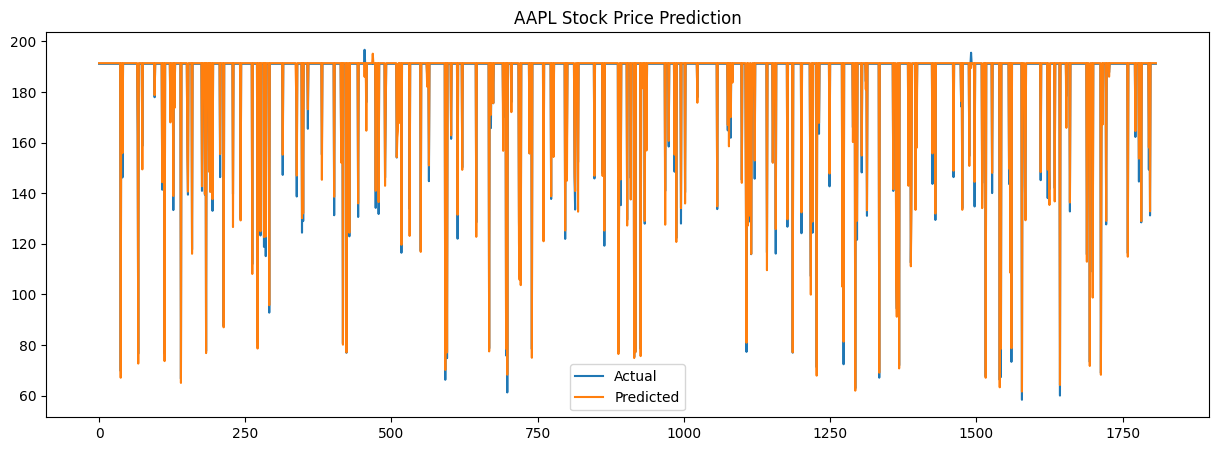

In [159]:
# @title Testing

predictions, y_test_actual = evaluate_model_predictions(model, X_test_tensor, y_test_tensor, scaler_y)

# Metrics
calculate_regression_metrics(y_test_actual, predictions)

# Plotting
print("\n")
plt.figure(figsize=(15, 5))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title(f'{symbol} Stock Price Prediction')
plt.legend()
plt.show()

# Interpretation
# The plot shows how well the LSTM model with attention mechanism can predict the future values of a time series.
# The MSE provides a quantitative measure of the model's prediction accuracy.


#### Live Prediction Experiments

In [160]:
def train_and_evaluate_model(ticker, start_date, end_date, hidden_dim=50, learning_rate=0.01, epochs=100, test_size=0.2, random_state=42):
  """
  Downloads stock data, prepares it for time series prediction, trains an
  LSTM with Attention model, evaluates its performance, and plots the results.

  Args:
    ticker (str): The stock ticker symbol (e.g., 'AAPL').
    start_date (str): The start date for data fetching (YYYY-MM-DD).
    end_date (str): The end date for data fetching (YYYY-MM-DD).
    hidden_dim (int): The number of hidden units in the LSTM layer.
    learning_rate (float): The learning rate for the optimizer.
    epochs (int): The number of training epochs.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): The seed used by the random number generator for splitting.

  Returns:
    model: The trained model.
    scaler: The scaler used to normalize the data.
  """

  # Download data
  data = yf.download(ticker, start=start_date, end=end_date)

  # Use the 'Close' price for prediction
  close_prices = data['Close'].values

  # Normalize the data
  scaler = MinMaxScaler(feature_range=(0, 1))
  close_prices_scaled = scaler.fit_transform(close_prices.reshape(-1, 1))

  # Prepare the dataset
  X = close_prices_scaled[:-1]
  y = close_prices_scaled[1:]

  # Reshape for LSTM
  X = X.reshape(-1, 1, 1)
  y = y.reshape(-1, 1)

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Convert to PyTorch tensors
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

  # Instantiate and train the model
  # Ensure LSTMAttention class is defined before this function
  model = LSTMAttention(input_dim=1, hidden_dim=hidden_dim)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Training loop
  for epoch in range(epochs):
      model.train()
      optimizer.zero_grad()
      output = model(X_train_tensor)
      loss = criterion(output, y_train_tensor)
      loss.backward()
      optimizer.step()

      if epoch % 10 == 0:
          model.eval()
          test_pred = model(X_test_tensor)
          test_loss = criterion(test_pred, y_test_tensor)
          print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')


  # Predictions
  # Ensure evaluate_model_predictions function is defined before this function
  # Create a scaler for y specifically for inverse transforming
  scaler_y = MinMaxScaler(feature_range=(0, 1))
  scaler_y.fit(y) # Fit scaler_y on the original scaled y data
  predictions_actual, y_test_actual = evaluate_model_predictions(model, X_test_tensor, y_test_tensor, scaler_y)

  # Plotting
  plt.figure(figsize=(15, 5))
  plt.plot(y_test_actual, label='Actual')
  plt.plot(predictions_actual, label='Predicted')
  plt.title(f'{ticker} Stock Price Prediction')
  plt.legend()
  plt.show()

  # Calculate Metrics
  # Ensure calculate_regression_metrics function is defined before this function
  calculate_regression_metrics(y_test_actual, predictions_actual)

  return model, scaler



[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.44494912028312683, Test Loss: 0.043873757123947144
Epoch 10, Loss: 0.05683965981006622, Test Loss: 0.08688977360725403
Epoch 20, Loss: 0.05336673557758331, Test Loss: 0.0577567033469677
Epoch 30, Loss: 0.03129202872514725, Test Loss: 0.030793271958827972
Epoch 40, Loss: 0.008872618898749352, Test Loss: 0.008067891001701355
Epoch 50, Loss: 0.002062648767605424, Test Loss: 0.001356647815555334
Epoch 60, Loss: 0.0018765864660963416, Test Loss: 0.0013436436420306563
Epoch 70, Loss: 0.0006740633980371058, Test Loss: 0.0008757149917073548
Epoch 80, Loss: 0.0007049227133393288, Test Loss: 0.0008763069054111838
Epoch 90, Loss: 0.0005478881648741663, Test Loss: 0.0006599020562134683


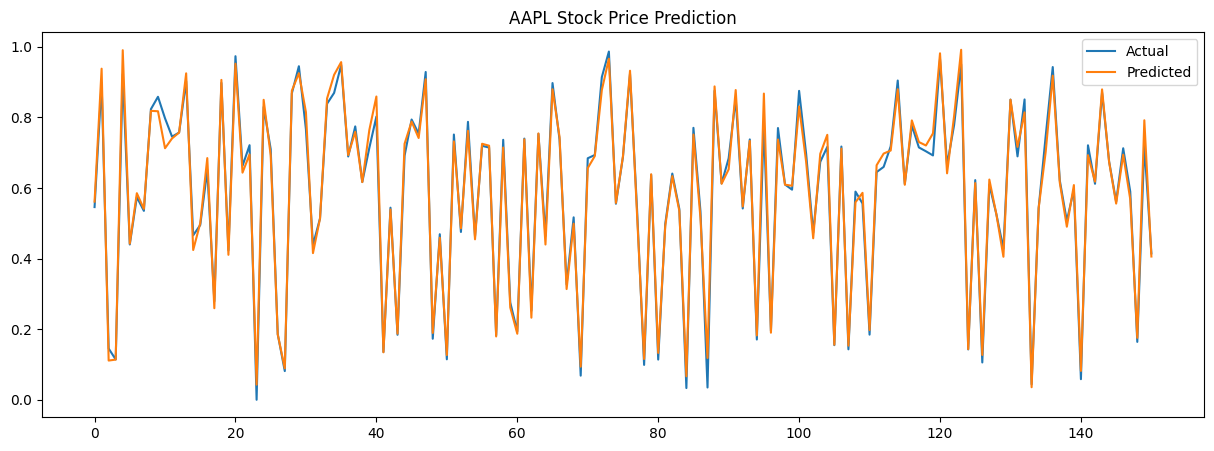

Mean Squared Error: 0.0006441030418500304
Root Mean Squared Error: 0.025379185208552903
Mean Absolute Error: 0.018660888075828552
R^2 Score: 0.9903808236122131


In [168]:
# usage:
model_live, scaler_live = train_and_evaluate_model('AAPL', '2020-01-01', '2023-01-01', learning_rate=0.1)
#

[*********************100%***********************]  1 of 1 completed


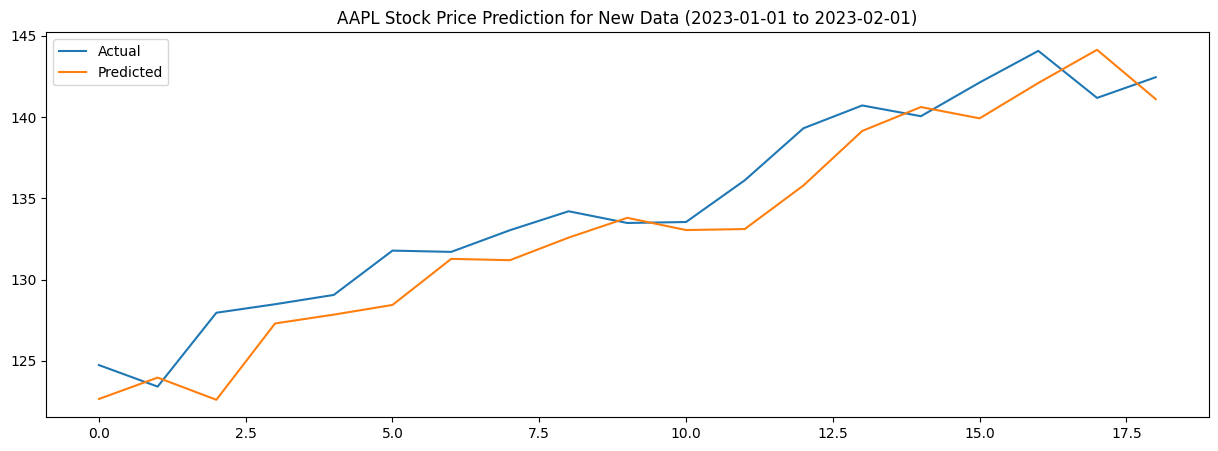

Mean Squared Error: 5.122598506749212
Root Mean Squared Error: 2.263315821256329
Mean Absolute Error: 1.8715041311163645
R^2 Score: 0.8605100100762204


In [165]:
# @title On new data

def predict_and_evaluate_on_new_data(model, scaler, ticker, start_date, end_date):
  """
  Fetches new stock data, preprocesses it, makes predictions using a trained
  model, and evaluates the model's performance on the new data.

  Args:
    model (nn.Module): The trained PyTorch model.
    scaler (MinMaxScaler): The scaler used to normalize the data during training.
    ticker (str): The stock ticker symbol (e.g., 'AAPL').
    start_date (str): The start date for fetching new data (YYYY-MM-DD).
    end_date (str): The end date for fetching new data (YYYY-MM-DD).

  Returns:
    None: Prints metrics and displays a plot for the new data.
  """

  # Step 1: Fetch additional data
  additional_data = yf.download(ticker, start=start_date, end=end_date)

  # Step 2: Preprocess the new data
  new_close_prices = additional_data['Close'].values
  new_close_prices_scaled = scaler.transform(new_close_prices.reshape(-1, 1))

  # Preparing the new dataset for prediction
  # Ensure there's enough data to create input and target sequences
  if len(new_close_prices_scaled) < 2:
      print(f"Not enough data points in the new date range ({start_date} to {end_date}) to make predictions.")
      return

  X_new = new_close_prices_scaled[:-1]
  y_new_actual = new_close_prices_scaled[1:]

  X_new = X_new.reshape(-1, 1, 1)
  y_new_actual = y_new_actual.reshape(-1, 1)

  # Convert to PyTorch tensors
  X_new_tensor = torch.tensor(X_new, dtype=torch.float32)
  y_new_actual_tensor = torch.tensor(y_new_actual, dtype=torch.float32)

  # Step 3: Make predictions
  model.eval()
  new_predictions = model(X_new_tensor).detach().numpy()
  new_predictions_actual = scaler.inverse_transform(new_predictions)
  y_new_actual_transformed = scaler.inverse_transform(y_new_actual)

  # Step 4: Evaluate the Model
  plt.figure(figsize=(15, 5))
  plt.plot(y_new_actual_transformed, label='Actual')
  plt.plot(new_predictions_actual, label='Predicted')
  plt.title(f'{ticker} Stock Price Prediction for New Data ({start_date} to {end_date})')
  plt.legend()
  plt.show()

  # Calculate metrics
  calculate_regression_metrics(y_new_actual_transformed, new_predictions_actual)

predict_and_evaluate_on_new_data(model_live, scaler_live, 'AAPL', '2023-01-01', '2023-02-01')


In [ ]:
stop

### PR Model

Model for Pattern Recognition or in this case detection

In [192]:
print("Value counts for 'next_4' after dropping NaNs:")
print(pr_df['next_4'].value_counts())

Value counts for 'next_4' after dropping NaNs:
next_4
NaN     6035
UUUU      91
UDDU      76
DUDU      74
UDUD      73
DUUD      70
UDUU      69
UUDU      68
UUDD      64
DDUU      62
DUUU      61
UUUD      61
DDUD      58
DUDD      57
UDDD      43
DDDU      43
DDDD      28
Name: count, dtype: int64


In [169]:
# Check for NaNs or infinite values in the data

# Check for NaNs in the entire DataFrame first, as dropna handles all column types
if pr_df.isnull().values.any():
    print('Data contains NaN values. These rows will be dropped.')
    pr_df.dropna(inplace=True)

# Define the numerical columns to check for infinite values
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # 'Adj Close'

# Check for infinite values only in the numerical columns
if np.isinf(pr_df[numerical_cols].values).any():
    print('Data contains infinite values in numerical columns. These will be replaced.')
    # Replace infinite values with NaN only in numerical columns
    pr_df[numerical_cols].replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows where numerical columns now contain NaNs (from the replacement)
    pr_df.dropna(subset=numerical_cols, inplace=True)


# Ensure all 'Movement' column data are strings, and encode 'next_4' as categorical labels
# This part is correct and should be kept
pr_df['Movement'] = pr_df['Movement'].astype(str)

# Ensure 'next_4' exists and handle potential NaNs after dropping rows
if 'next_4' in pr_df.columns:
    # Recalculate pattern_to_label after dropping rows to ensure it only includes present patterns
    unique_patterns = pr_df['next_4'].dropna().unique()
    pattern_to_label = {pattern: idx for idx, pattern in enumerate(unique_patterns)}
    pr_df['next_4_label'] = pr_df['next_4'].map(pattern_to_label)
else:
    raise ValueError("'next_4' column not found in pr_df after processing.")


# Select features and labels
# Ensure the columns exist before selecting
features_list = ['Open', 'High', 'Low', 'Close', 'Volume'] # 'Adj Close'
# Filter features_list to include only columns present in pr_df
existing_features = [col for col in features_list if col in pr_df.columns]

if 'next_4_label' not in pr_df.columns:
    raise ValueError("'next_4_label' column was not created. Check 'next_4' column processing.")



Data contains NaN values. These rows will be dropped.


In [183]:
features = pr_df[existing_features].values
labels = pr_df['next_4_label'].values

print(features.shape, labels.shape)

(1006, 5) (1006,)


In [184]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)

# Reshape for LSTM with attention
X = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])
y = labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Instantiate the model
model = LSTMAttentionClassifier(input_dim=X_train_tensor.shape[-1], hidden_dim=50, output_dim=len(pattern_to_label))
print(model)


LSTMAttentionClassifier(
  (lstm): LSTM(5, 50, batch_first=True)
  (attention): Linear(in_features=50, out_features=50, bias=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [187]:
y_train_tensor


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [180]:

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model and data to the determined device
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.001


Using device: cpu


In [179]:
# @title Training with memory management

epochs = 100
batch_size = 32 # Reduce batch size
gradient_accumulation_steps = 4 # Accumulate gradients over several batches

# Create PyTorch DataLoader for efficient batching
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Checking for NaNs/Infs in X_train_tensor:", torch.isnan(X_train_tensor).any() or torch.isinf(X_train_tensor).any())
print("Checking for NaNs/Infs in y_train_tensor:", torch.isnan(y_train_tensor).any() or torch.isinf(y_train_tensor).any())


for epoch in range(epochs):
    model.train()
    total_train_loss = torch.tensor(0.0, dtype=torch.float32, device=device)
    optimizer.zero_grad() # Zero gradients at the start of the epoch

    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to device (already done for tensors, but good practice in loop)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Check outputs for NaNs/Infs
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print(f"Epoch {epoch}, Batch {i}: Model output contains NaN or Inf!")
            print("Example output:", outputs[:10])
            # You might want to stop here or implement a more robust NaN handling strategy
            break # Break from batch loop

        loss = criterion(outputs, labels)

        # Check loss for NaNs/Infs
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            print(f"Epoch {epoch}, Batch {i}: Loss is NaN or Inf!")
            print("Loss value:", loss.item())
            break # Break from batch loop


        # Backward pass and optimize (with gradient accumulation)
        loss = loss / gradient_accumulation_steps # Normalize loss
        loss.backward() # Accumulate gradients

        # Step the optimizer and clear gradients only after accumulation steps
        if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(train_loader):
            # Clip gradients to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad() # Zero gradients after stepping

        total_train_loss += loss.item() * gradient_accumulation_steps # Scale loss back


    # If NaN loss/output occurred in the inner loop, break the outer loop too
    if torch.isnan(total_train_loss).any() or torch.isinf(total_train_loss).any() or (torch.isnan(outputs).any() or torch.isinf(outputs).any()):
         print(f"Epoch {epoch}: Stopping training due to NaN/Inf.")
         break

    avg_train_loss = total_train_loss / len(train_loader)

    if epoch % 10 == 0:
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                 inputs, labels = inputs.to(device), labels.to(device)
                 test_outputs = model(inputs)
                 test_loss = criterion(test_outputs, labels)
                 total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        print(f'Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Checking for NaNs/Infs in X_train_tensor: tensor(False)
Checking for NaNs/Infs in y_train_tensor: tensor(False)
Epoch 0, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 10, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 20, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 30, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 40, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 50, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 60, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 70, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 80, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 90, Train Loss: 0.0000, Test Loss: 0.0000


In [ ]:
# @title Testing and Evaluation

model.eval()
all_predictions = []
all_actual = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # For classification, get the predicted class index
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_actual.extend(labels.cpu().numpy())

# Convert labels back to original patterns for interpretation
label_to_pattern = {idx: pattern for pattern, idx in pattern_to_label.items()}
predicted_patterns = [label_to_pattern[label] for label in all_predictions]
actual_patterns = [label_to_pattern[label] for label in all_actual]

accuracy = accuracy_score(all_actual, all_predictions)
print(f'\nAccuracy: {accuracy:.4f}')

# Print classification report (precision, recall, f1-score)
print('\nClassification Report:')
print(classification_report(all_actual, all_predictions, target_names=list(pattern_to_label.keys())))

# Note: Plotting is not straightforward for classification of patterns
# You might plot accuracy per epoch or look at confusion matrix
# Example: Plotting could involve showing actual vs. predicted patterns for a subset of test data


In [ ]:
# df.to_csv('./data.csv')

In [ ]:
stop

## Tensorflow (Advanced)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))


In [ ]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])


In [ ]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# @title LSTM

model = Sequential()

# Adding Input layer as the first layer
model.add(Input(shape=(X_train.shape[1], 1))) # Use Input layer with the correct shape

# Adding LSTM layers
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))  # Only the last time step

# Adding a Dense layer to match the output shape with y_train
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)


In [ ]:
# @title LSTM with Attention

model = Sequential()

# Adding Input layer as the first layer
model.add(Input(shape=(X_train.shape[1], 1))) # Use Input layer with the correct shape

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)



In [ ]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
model.summary()


In [ ]:
# Assume 'data' is your preprocessed dataset
train_size = int(len(aapl_data) * 0.8)
train_data, test_data = aapl_data[:train_size], aapl_data[train_size:]


In [ ]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)


In [ ]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)


# Unverified Predictions

For Real-life scenarios

In [ ]:
# @title Price for the next 4 days

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)


In [ ]:
# @title Prices for the next 4 days

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)


In [ ]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()



In [ ]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta


def predict_stock_price(input_date):
    # Check if the input date is a valid date format
    try:
        input_date = pd.to_datetime(input_date)
    except ValueError:
        print("Invalid Date Format. Please enter date in YYYY-MM-DD format.")
        return

    # Fetch data from yfinance
    end_date = input_date
    start_date = input_date - timedelta(days=90)  # Fetch more days to ensure we have 60 trading days
    data = yf.download('AAPL', start=start_date, end=end_date)

    if len(data) < 60:
        print("Not enough historical data to make a prediction. Try an earlier date.")
        return

    # Prepare the data
    closing_prices = data['Close'].values[-60:]  # Last 60 days
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

    # Make predictions
    predicted_prices = []
    current_batch = scaled_data.reshape(1, 60, 1)

    for i in range(4):  # Predicting 4 days
        next_prediction = model.predict(current_batch)
        next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
        current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
        predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

    # Output the predictions
    for i, price in enumerate(predicted_prices, 1):
        print(f"Day {i} prediction: {price}")

# Example use
user_input = input("Enter a date (YYYY-MM-DD) to predict AAPL stock for the next 4 days: ")
predict_stock_price(user_input)
